In [1]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pickle
import dynchro
from moepy import lowess

In [2]:
%load_ext autoreload
%autoreload 2

# 1. scatter plots: celltypes and pseudotime

In [3]:
adata = ad.read_h5ad("figures/wildtype_start.h5ad")
irf8 = ad.read_h5ad("figures/irf8_start.h5ad")
gfi1 = ad.read_h5ad("figures/gfi1_start.h5ad")
both = ad.read_h5ad("figures/both_start.h5ad")

In [4]:
adata.obsm

AxisArrays with keys: X_dr, X_mlle, X_spring, X_stream_S4, X_vis, X_vis_umap

In [46]:
colors = ["#ffc800","#f6992d","#ed6a5a","#a75a5a","#60495a","#4c7680","#38a3a5","#7dba60","#c2d11b"]
colors = ["#F857B4", "#F86557", "#F8D157", "#B4F857", "#57F865", "#57F8D1", "#57B4F8", "#6557F8", "#D157F8"]
colors = ["#906DE3", "#DF6DE3", "#E36D99", "#E3906D", "#E3DF6D", "#99E36D", "#6DE390", "#6DE3DF", "#6D99E3"]
colors = ["#F3CB57", "#B3F357", "#57F363", "#57F3CB", "#57B3F3", "#6357F3", "#CB57F3", "#F357B3", "#F36357"]
colors = ["#EF69BA", "#EF7269", "#EFCB69", "#BAEF69", "#69EF72", "#69EFCB", "#69BAEF", "#7269EF", "#CB69EF"]
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)

/tmp/ipykernel_117182/743962589.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)


In [47]:
colors

((0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353))

In [40]:
colors + color

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 0.7372549019607844,
 0.5019607843137255,
 0.7411764705882353)

In [38]:
# to rgb
color = plt.cm.get_cmap("Set3").colors[9]
import matplotlib
matplotlib.colors.to_hex(color)

/tmp/ipykernel_117182/1370895054.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap("Set3").colors[9]


'#bc80bd'

In [83]:
def get_colors(colors, labels):
    color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 7.5, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

In [352]:
def plot_celltypes(adata, axes):
    xs = adata.obsm['X_dr'][:, 0]
    ys = adata.obsm['X_dr'][:, 1]
    labels = adata.obs['label'].values

    translated_colors, handles, labels = get_colors(colors, labels)

    ax = axes[0]

    ax.scatter(xs, ys, c=translated_colors,  s=60, edgecolors = 'k')

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")

    # ax.set_xlabel("Flat tree plot")
    # ax.xaxis.set_label_coords(0.25, 0.95)
    
    axes[1].axis('off')

    axes[1].legend(handles=handles, labels=labels, title="", loc='upper center', frameon=False, fontsize="x-small", title_fontsize="small")
    
    return ax

In [134]:
import matplotlib.colors as clr
import matplotlib as mpl
def plot_pseudotime(adata, axes, title):

    xs = adata.obsm['X_dr'][:, 0]
    ys = adata.obsm['X_dr'][:, 1]
    colors = adata.obs['pseudotime'].values
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())

    blue_reversed = plt.get_cmap('Blues_r')
    tints = ["#69BAEF", "#80C2F1", "#95CBF3", "#A9D3F5", "#BBDCF7", "#CDE5F9", "#DEEDFB", "#EEF6FD", "#FFFFFF"]
    shades = ["#4DA2D5", "#2C8ABC", "#0073A3", "#005D8B", "#004774"][::-1]
    blues = shades +tints

    palette = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)

    ax = axes[0]
    ax.scatter(xs, ys, c=norm_colors, cmap=palette, s=60, edgecolors = 'k')

    cmap = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    axes[1].axis('off')

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=axes[1], orientation='vertical', label='Pseudotime',
                fraction=0.75, shrink=0.75, ticks=[0, 1])

    ax.set_title(title)

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")


Text(0.0, 1.0, '(b) Wild type pseudotime')

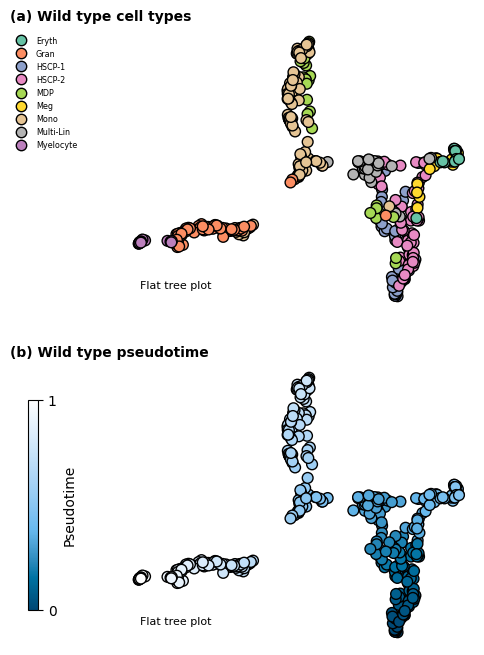

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 8), gridspec_kw={'width_ratios': [2, 10]})
# axes[1].axis('off')
plot_celltypes(adata, [axes[0, 1], axes[0, 0]])
axes[0, 1].set_title("")
axes[0, 0].set_title("(a) Wild type cell types", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

plot_pseudotime(adata, [axes[1, 1], axes[1, 0]], "Pseudotime")
axes[1, 1].set_title("")
axes[1, 0].set_title("(b) Wild type pseudotime", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

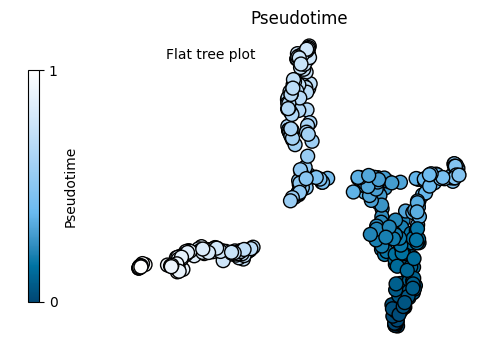

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), gridspec_kw={'width_ratios': [1, 5]})
plot_pseudotime(adata, axes[::-1], "Pseudotime")


Text(0.5, 1.0, 'Thing')

<Axes: title={'center': 'Cell types'}>

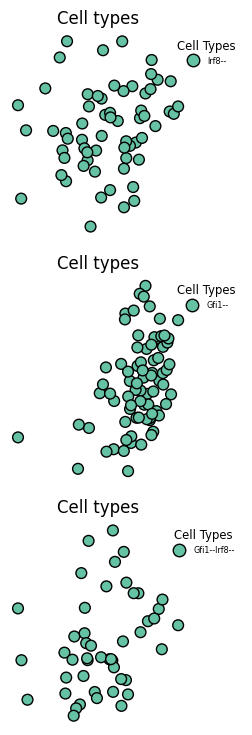

In [52]:
fig, ax = plt.subplots(nrows=3, ncols = 2, figsize=(3, 9), width_ratios=[10, 2])
plot_celltypes(irf8, [ax[0, 0], ax[0, 1]])
plot_celltypes(gfi1, [ax[1, 0], ax[1, 1]])
plot_celltypes(both, [ax[2, 0], ax[2, 1]])

In [30]:
import seaborn as sns
import matplotlib.colors as clr
import matplotlib as mpl
def plot_pseudotime(adata, axes, title):

    xs = adata.obsm['X_dr'][:, 0]
    ys = adata.obsm['X_dr'][:, 1]
    colors = adata.obs['pseudotime'].values
    norm_colors = (colors - colors.min()) / (colors.max() - colors.min())

    blue_reversed = plt.get_cmap('Blues_r')
    tints = ["#69BAEF", "#80C2F1", "#95CBF3", "#A9D3F5", "#BBDCF7", "#CDE5F9", "#DEEDFB", "#EEF6FD", "#FFFFFF"]
    shades = ["#4DA2D5", "#2C8ABC", "#0073A3", "#005D8B", "#004774"][::-1]
    blues = shades +tints

    palette = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)

    ax = axes[0]
    ax.scatter(xs, ys, c=norm_colors, cmap=palette, s=100, edgecolors = 'k')

    cmap = clr.LinearSegmentedColormap.from_list("custom", blues, N=256)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    axes[1].axis('off')

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=axes[1], orientation='vertical', label='Pseudotime',
                fraction=0.75, shrink=0.75, ticks=[0, 1])

    ax.set_title(title)

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.set_xlabel("Flat tree plot")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.25, 0.95)
    ax.set_ylabel("")


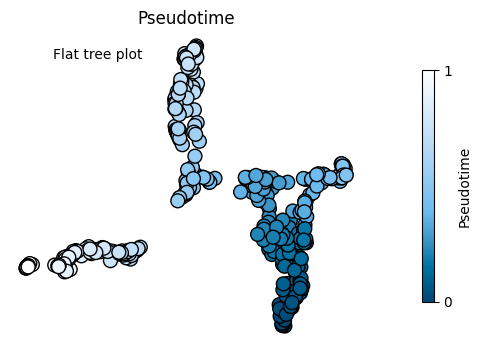

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), gridspec_kw={'width_ratios': [5, 1]})
plot_pseudotime(adata, axes, "Pseudotime")

TypeError: 'Axes' object is not subscriptable

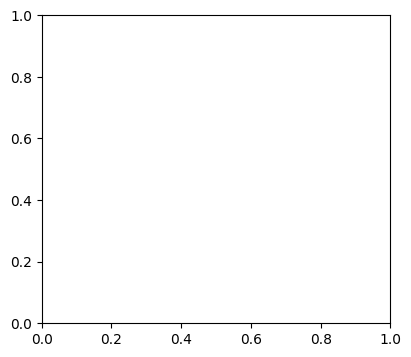

In [32]:
fig, ax = plt.subplots(figsize=(4.5, 4))
plot_pseudotime(adata, ax, "Inferred pseudotime on wildtype")

TypeError: 'Axes' object is not subscriptable

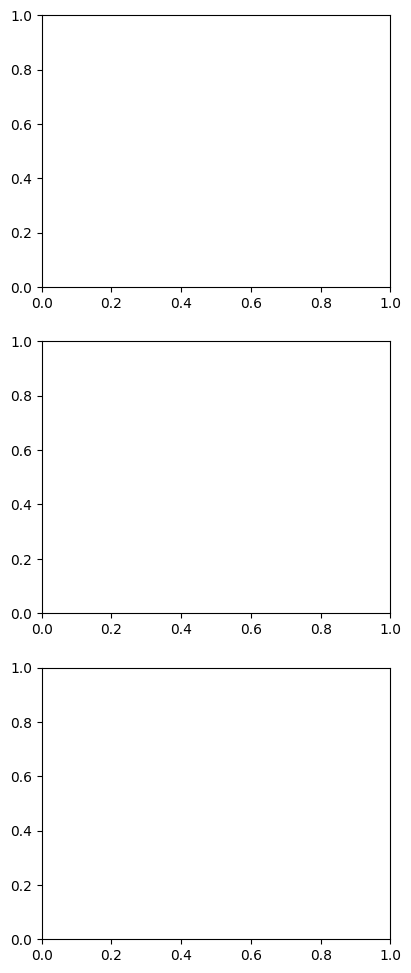

In [33]:
fig, ax = plt.subplots(nrows=3, figsize=(4.5, 12))
plot_pseudotime(irf8, ax[0], "Inferred pseudotime on irf8 knockout")
plot_pseudotime(gfi1, ax[1], "Inferred pseudotime on gfi1 knockout")
plot_pseudotime(both, ax[2], "Inferred pseudotime on both knockouts")

# 2. cost over pseudotime of alignments

## 2.1 individual plots

In [139]:
with open("figures/2_dynchro_warpings.pkl", "rb") as f:
    warpings = pickle.load(f)
    warping_irf8, warping_gfi1, warping_both = warpings

defaultdict(<class 'list'>, {'Lsk.65': np.float64(87.17672929094589), 'Lsk.26': np.float64(89.82330380448283), 'Lsk.31': np.float64(87.06766074553957), 'Lsk.50': np.float64(89.74449298700807), 'Lsk.49': np.float64(89.01658438458495), 'Lsk.63': np.float64(88.9953756629805), 'Lsk.80': np.float64(91.33858663843404), 'Lsk.78': np.float64(94.18047506897145), 'Lsk.24': np.float64(90.40758737136525), 'Lsk.22': np.float64(85.86937347683313), 'Lsk.17': np.float64(80.51407165580152), 'Lsk.18': np.float64(86.7038409441658), 'Lsk.88': np.float64(89.64488416342664), 'Lsk.51': np.float64(85.30795717063309), 'Lsk.73': np.float64(88.0767202900976), 'Lsk.16': np.float64(80.76442375119821), 'Lsk.81': np.float64(87.92177445809205), 'Lsk.43': np.float64(88.40143960193535), 'Lsk.89': np.float64(96.80579920376202), 'Lsk.44': np.float64(99.88090119680096), 'Lsk.85': np.float64(94.23307659642614), 'Lsk.4': np.float64(96.50321034942716), 'Lsk.27': np.float64(94.12726425514356), 'Cmp.32': np.float64(90.12830313

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

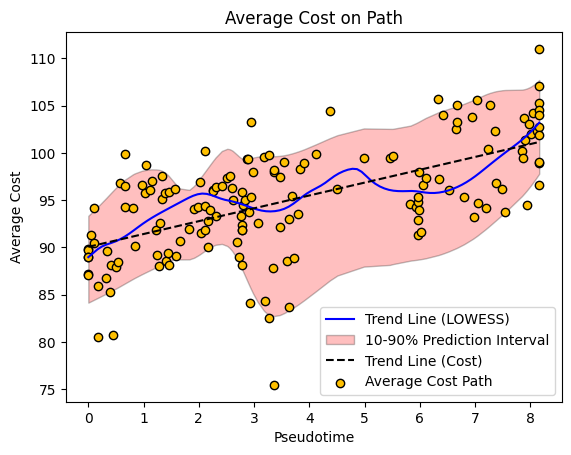

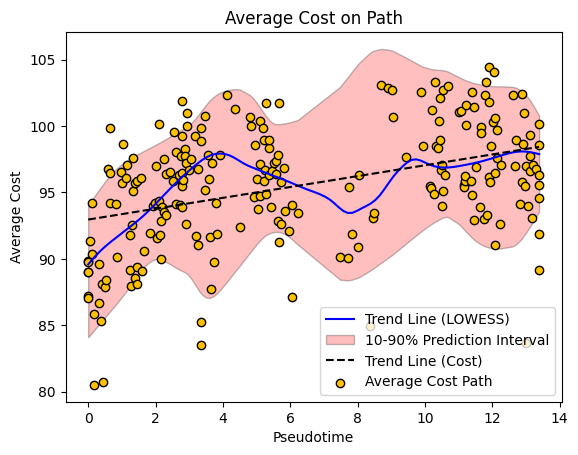

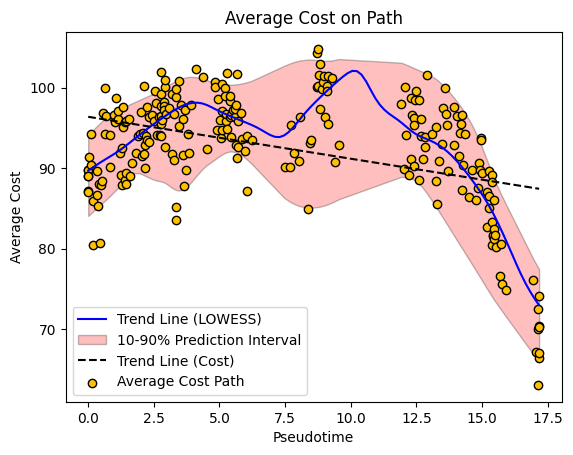

In [140]:
# plot warping of irf8 to granulocytic and monocytic lineages

#warping_irf8[3] --> has warpings for erythro, mono, gran
irf8_eryt = warping_irf8[3][0]
irf8_mono = warping_irf8[3][1]
irf8_gran = warping_irf8[3][2]

irf8_eryt = dynchro.tl.avg_cost_path(irf8_eryt, dtw_key="irf8_erythrocytic_irf8")
irf8_mono = dynchro.tl.avg_cost_path(irf8_mono, dtw_key="irf8_monocytic_irf8")
irf8_gran = dynchro.tl.avg_cost_path(irf8_gran, dtw_key="irf8_granulocytic_irf8")

dynchro.pl.plot_avg_cost_path(irf8_eryt, pseudotime_key="pseudotime", dtw_key="irf8_erythrocytic_irf8")
dynchro.pl.plot_avg_cost_path(irf8_mono, pseudotime_key="pseudotime", dtw_key="irf8_monocytic_irf8")
dynchro.pl.plot_avg_cost_path(irf8_gran, pseudotime_key="pseudotime", dtw_key="irf8_granulocytic_irf8")

defaultdict(<class 'list'>, {'Lsk.65': np.float64(86.96397490546026), 'Lsk.26': np.float64(87.24846430650113), 'Lsk.31': np.float64(93.35305722311108), 'Lsk.50': np.float64(94.01215578542548), 'Lsk.49': np.float64(92.33798268632101), 'Lsk.63': np.float64(93.42470330764414), 'Lsk.80': np.float64(98.8104811647999), 'Lsk.78': np.float64(94.49346702041949), 'Lsk.24': np.float64(94.26577899297197), 'Lsk.22': np.float64(91.39692075860597), 'Lsk.17': np.float64(94.43497078928897), 'Lsk.18': np.float64(96.85957950006201), 'Lsk.88': np.float64(98.33607043898058), 'Lsk.51': np.float64(93.18567005928597), 'Lsk.73': np.float64(97.94336983655481), 'Lsk.16': np.float64(92.77706720424871), 'Lsk.81': np.float64(97.08157933069211), 'Lsk.43': np.float64(87.5729429989575), 'Lsk.89': np.float64(97.53981034722557), 'Lsk.44': np.float64(99.79176463069199), 'Lsk.85': np.float64(93.47705659485271), 'Lsk.4': np.float64(93.65765470231078), 'Lsk.27': np.float64(96.14942591042839), 'Cmp.32': np.float64(93.3006205

100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

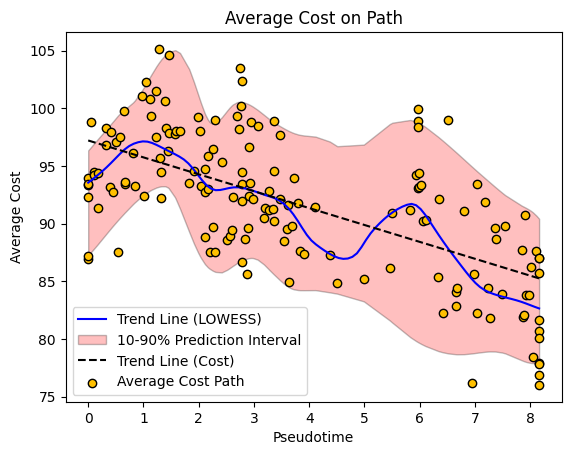

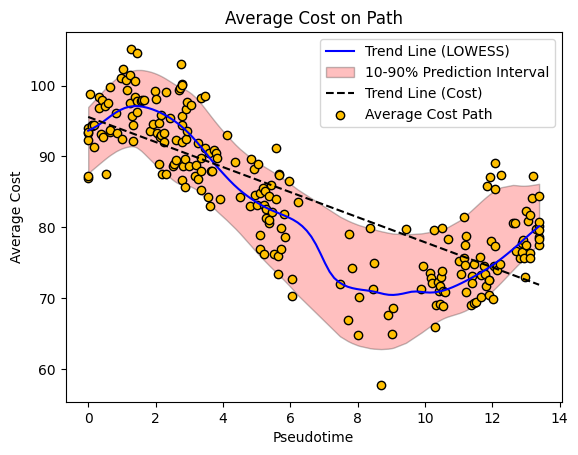

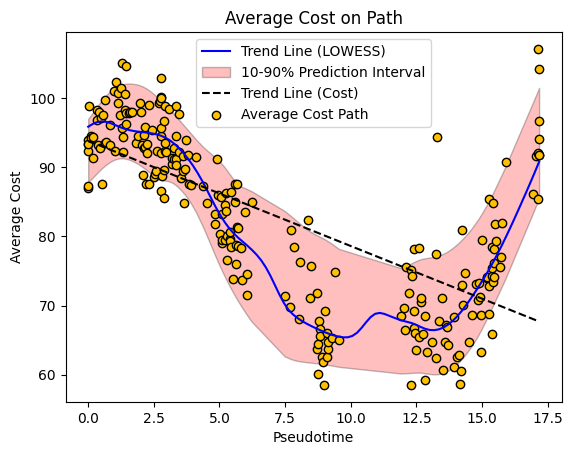

In [141]:
gfi1_eryt = warping_gfi1[3][0]
gfi1_mono = warping_gfi1[3][1]
gfi1_gran = warping_gfi1[3][2]

gfi1_eryt = dynchro.tl.avg_cost_path(gfi1_eryt, dtw_key="gfi1_erythrocytic_gfi1")
gfi1_mono = dynchro.tl.avg_cost_path(gfi1_mono, dtw_key="gfi1_monocytic_gfi1")
gfi1_gran = dynchro.tl.avg_cost_path(gfi1_gran, dtw_key="gfi1_granulocytic_gfi1")

dynchro.pl.plot_avg_cost_path(gfi1_eryt, pseudotime_key="pseudotime", dtw_key="gfi1_erythrocytic_gfi1")
dynchro.pl.plot_avg_cost_path(gfi1_mono, pseudotime_key="pseudotime", dtw_key="gfi1_monocytic_gfi1")
dynchro.pl.plot_avg_cost_path(gfi1_gran, pseudotime_key="pseudotime", dtw_key="gfi1_granulocytic_gfi1")

## 2.1 2x2 plot

In [ ]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


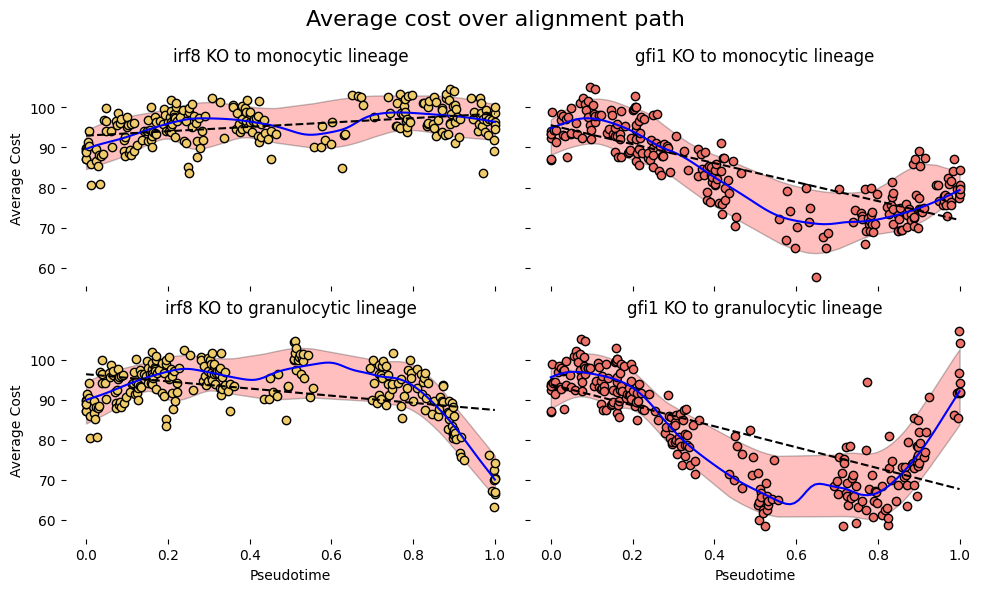

In [143]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharey=True, sharex=True)

irf8_mono.obs["norm_pseudotime"] = norm(irf8_mono.obs["pseudotime"])
irf8_gran.obs["norm_pseudotime"] = norm(irf8_gran.obs["pseudotime"])
gfi1_mono.obs["norm_pseudotime"] = norm(gfi1_mono.obs["pseudotime"])
gfi1_gran.obs["norm_pseudotime"] = norm(gfi1_gran.obs["pseudotime"])

# irf8_mono.obs["norm_pseudotime"] = (irf8_mono.obs["pseudotime"] - irf8_mono.obs["pseudotime"].min()) / (irf8_mono.obs["pseudotime"].max() - irf8_mono.obs["pseudotime"].min())
# irf8_gran.obs["norm_pseudotime"] = (irf8_gran.obs["pseudotime"] - irf8_gran.obs["pseudotime"].min()) / (irf8_gran.obs["pseudotime"].max() - irf8_gran.obs["pseudotime"].min())
# gfi1_mono.obs["norm_pseudotime"] = (gfi1_mono.obs["pseudotime"] - gfi1_mono.obs["pseudotime"].min()) / (gfi1_mono.obs["pseudotime"].max() - gfi1_mono.obs["

dynchro.pl.plot_avg_cost_path(irf8_mono, pseudotime_key="norm_pseudotime", dtw_key="irf8_monocytic_irf8", color = "#EFCB69", ax=axs[0,0])
dynchro.pl.plot_avg_cost_path(irf8_gran, pseudotime_key="norm_pseudotime", dtw_key="irf8_granulocytic_irf8", color = "#EFCB69", ax=axs[1,0])
dynchro.pl.plot_avg_cost_path(gfi1_mono, pseudotime_key="norm_pseudotime", dtw_key="gfi1_monocytic_gfi1", color="#EF7269", ax=axs[0,1])
dynchro.pl.plot_avg_cost_path(gfi1_gran, pseudotime_key="norm_pseudotime", dtw_key="gfi1_granulocytic_gfi1", color="#EF7269", ax=axs[1,1])

axs[0, 0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
axs[0, 1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
axs[1, 0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
axs[1, 1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

axs[0,0].get_legend().remove()
axs[0,1].get_legend().remove()
axs[1,0].get_legend().remove()
axs[1,1].get_legend().remove()

axs[0, 0].set_title("irf8 KO to monocytic lineage")
axs[1, 0].set_title("irf8 KO to granulocytic lineage")
axs[0, 1].set_title("gfi1 KO to monocytic lineage")
axs[1, 1].set_title("gfi1 KO to granulocytic lineage")

axs[0, 0].xaxis.label.set_visible(False)
axs[0, 1].xaxis.label.set_visible(False)
axs[0, 1].yaxis.label.set_visible(False)
axs[1, 1].yaxis.label.set_visible(False)

fig.tight_layout()
fig.suptitle("Average cost over alignment path", fontsize=16)
fig.subplots_adjust(top=0.88)

# 3. bootstrapping

In [457]:
import pickle
with open("figures/2_dynchro_bootstrap_results.pkl", "rb") as f:
    res_irf8, res_gfi1, res_both = pickle.load(f)

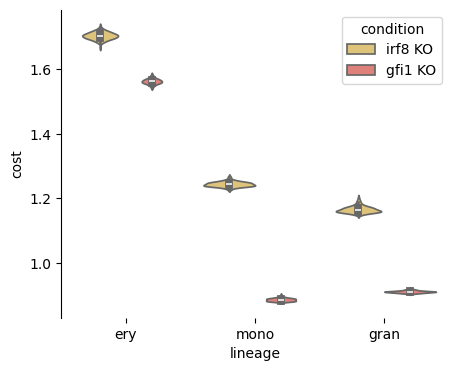

In [146]:
import pandas as pd

data_irf8 = pd.DataFrame({
    "ery": res_irf8[0],
    "mono": res_irf8[1],
    "gran": res_irf8[2]
})

data_gfi1 = pd.DataFrame({
    "ery": res_gfi1[0],
    "mono": res_gfi1[1],
    "gran": res_gfi1[2]
})

# append data_irf8 and data_gfi1 to a single dataframe with a column indicating the condition
data_irf8["condition"] = "irf8 KO"
data_gfi1["condition"] = "gfi1 KO"
# concatenate the two dataframes
data = pd.concat([data_irf8, data_gfi1], ignore_index=True)
# melt the dataframe to have a column for the lineage and a column for the cost
data = pd.melt(data, id_vars=["condition"], value_vars=["ery", "mono", "gran"], var_name="lineage", value_name="cost")

fig, axes = plt.subplots(1, 1, figsize=(5, 4), sharey=True)

import seaborn as sns
# sns.violinplot(data=data_irf8, palette=["#EFCB69", "#EFCB69", "#EFCB69"], ax=axes[0])
import matplotlib.pyplot as plt
# sns.violinplot(data=data_gfi1, palette=["#EF7269", "#EF7269", "#EF7269"], ax=axes[1])
# plt.show()

# axes[0].spines[['top', 'right', 'bottom']].set_visible(False)
# axes[1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# fig.tight_layout()

sns.violinplot(data=data, y="cost", hue="condition", x="lineage", palette=["#EFCB69", "#EF7269"])
axes.spines[['top', 'right', 'bottom']].set_visible(False)

In [468]:
data_irf8 = pd.DataFrame({
    "ery": res_irf8[0],
    "mono": res_irf8[1],
    "gran": res_irf8[2]
})

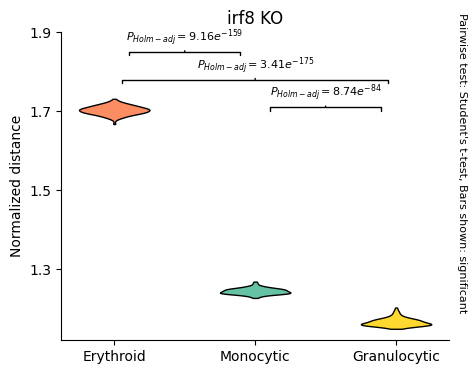

In [575]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
parts = ax.violinplot(data_irf8, showextrema = False)

violin_colors = [
    colors[0],
    colors[1],
    colors[6]
]
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(violin_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Erythroid", "Monocytic", "Granulocytic"])
ax.set_yticks([1.9, 1.7, 1.5, 1.3])
ax.set_ylabel("Normalized distance")
ax.set_title("irf8 KO")

pos1 = 1.5
pos2 = 2
label1 = '$P_{Holm-adj}=9.16e^{-159}$'
label2 = '$P_{Holm-adj}=3.41e^{-175}$'
label3 = '$P_{Holm-adj}=8.74e^{-84}$'

ax.annotate(label1, xy=(pos1, 1.85), xytext=(pos1, 1.86),
            fontsize=8, ha='center', va='bottom', xycoords='data', 
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))

ax.annotate(label2, xy=(2, 1.78), xytext=(2, 1.79),
            fontsize=8, ha='center', va='bottom', xycoords='data', 
            arrowprops=dict(arrowstyle='-[, widthB=12, lengthB=.3', lw=1.0))
ax.annotate(label3, xy=(2.5, 1.71), xytext=(2.5, 1.72),
            fontsize=8, ha='center', va='bottom', xycoords='data', 
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))

stat_text = "Pairwise test: Student's t-test, Bars shown: significant"
ax.text(3.5, 1.95, stat_text, fontsize=8, ha='right', va='top', rotation = 270)
plt.show()

In [464]:
data_irf8

,ery,mono,gran,condition
0,1.698250,1.243374,1.152621,irf8 KO
1,1.697057,1.240257,1.148612,irf8 KO
2,1.712452,1.262735,1.160732,irf8 KO
3,1.706220,1.249087,1.159197,irf8 KO
4,1.693021,1.236994,1.159342,irf8 KO
...,...,...,...,...
95,1.704085,1.248686,1.157724,irf8 KO
96,1.698237,1.238667,1.160385,irf8 KO
97,1.724646,1.251141,1.172916,irf8 KO
98,1.688488,1.239672,1.152710,irf8 KO


In [463]:
data

,condition,lineage,cost
0,irf8 KO,ery,1.698250
1,irf8 KO,ery,1.697057
2,irf8 KO,ery,1.712452
3,irf8 KO,ery,1.706220
4,irf8 KO,ery,1.693021
...,...,...,...
295,irf8 KO,gran,1.157724
296,irf8 KO,gran,1.160385
297,irf8 KO,gran,1.172916
298,irf8 KO,gran,1.152710


# 4. warping plots

In [153]:
with open("figures/2_dynchro_warpings_warpedfig_irf8.pkl", "rb") as f:
    warped_irf8, irf8_erythrocytic, irf8_monocytic, irf8_granulocytic = pickle.load(f)

with open("figures/2_dynchro_warpings_warpedfig_gfi1.pkl", "rb") as f:
    warped_gfi1, gfi1_erythrocytic, gfi1_monocytic, gfi1_granulocytic = pickle.load(f)

In [154]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list

In [449]:
def plot_warping(
        warped_datasets,
        extra_datasets = None,
        pseudotime_key: str = "pseudotime",
        dtw_key: str = "dtw",
        dimred_key: str = "X_umap",
        yshift = 0,
        ax = None,
        colors = None
):
# fix legends as well
    if ax is None:
        fig, ax = plt.subplots(figsize=(10.1, 3))

    # check only two warped datasets are provided
    assert  len(warped_datasets) <= 2, "Only two warped datasets are supported for plotting."

    # colors = ["#ff681c", "#1b2944", "#3abbba", "#315b25"]
    # colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']
    # colors = [ "#EF7269", "#EFCB69", "#69EF72",  "#69BAEF", "#7269EF", "#CB69EF"]
    datasets = extra_datasets + warped_datasets if extra_datasets else warped_datasets
    colors = colors[2:] + colors[:2]

    yshifts = [0, 0, yshift, 0]
    # print(yshifts)
    for dataset, color, yshift_ in zip(datasets, colors, yshifts):
        # print(ift_)
        dimred = dataset.obsm[dimred_key]
        pseudotime = norm(dataset.obs[pseudotime_key])
        ax.scatter(pseudotime, dimred[:, 1] + yshift_, c=color, edgecolors="black", linewidths=1.1, s=60)

    warping1 = flatten(warped_datasets[0].obs[f"{dtw_key}_path"])
    warping2 = flatten(warped_datasets[1].obs[f"{dtw_key}_path"])

    ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
    ds1_y = warped_datasets[0].obsm[dimred_key][warping2, 1] + yshifts[2]
    ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
    ds2_y = warped_datasets[1].obsm[dimred_key][warping1, 1]

    for x1, y1, x2, y2 in zip(ds1_x, ds1_y, ds2_x, ds2_y):
        ax.plot([x1, x2], [y1, y2], color='black', alpha = 0.2)

    ax.legend()

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.annotate("", xytext=(x0, y0), xy=(0.2, y0),
            arrowprops=dict(arrowstyle="->"))

    # ax.arrow(x0, y0 - 2, 0.2, 0, head_width=0.5, head_length=0.02, fc='k', ec='k')

    ax.set_xlabel("Pseudotime", fontdict={'fontsize': 8}, color='k')
    ax.xaxis.set_label_coords(0.055, 0.07)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

    return ax


/tmp/ipykernel_117182/1248426319.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
/tmp/ipykernel_117182/1248426319.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
/tmp/ipykernel_117182/1248426319.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_117182/1248426319.py:56: UserWarning: No artists with labels found to put in legend.  N

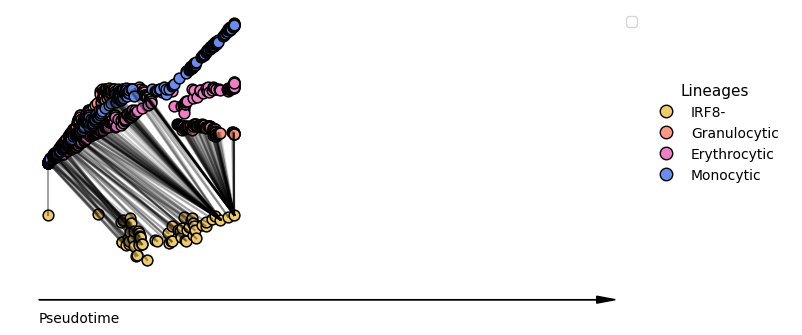

In [156]:
fig, axes = plt.subplots(figsize=(10.1, 4), nrows=1, ncols=2, width_ratios=[9, 1.1])

colors = ["#EFCB69","#CB69EF" , "#EF7269",  "#69BAEF", "#EF69BA", "#7269EF", "#69EF72"]
colors = [
    "#EFCB69",
    "#FF9784",
    "#EE7FC7",
    "#698DEF"
    ]

ax = plot_warping(
    warped_datasets = [warped_irf8, irf8_granulocytic],
    extra_datasets = [irf8_erythrocytic, irf8_monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap",
    yshift = -15,
    ax=axes[0],
    colors = colors
)
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors[:4]]
labels = ["IRF8-", "Granulocytic", "Erythrocytic", "Monocytic"]

# no spines and ticks
ax = axes[1]
ax.axis('off')

axes[1].legend(
    handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
    bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11
)



NameError: name 'warped_GFI1' is not defined

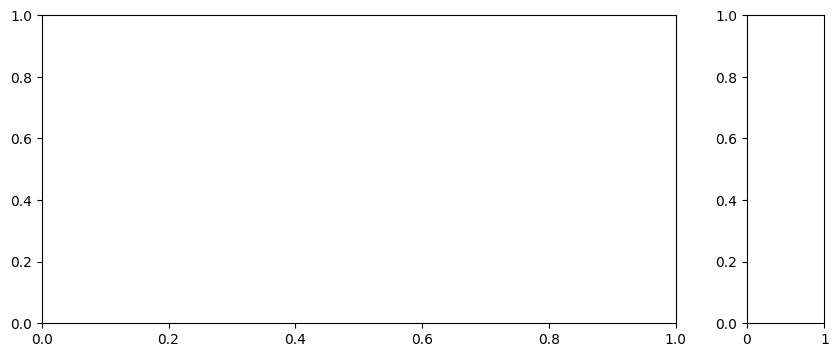

In [157]:
fig, axes = plt.subplots(figsize=(10.1, 4), nrows=1, ncols=2, width_ratios=[9, 1.1])


ax = plot_warping(
    warped_datasets = [warped_GFI1, monocytic],
    extra_datasets = [erythrocytic, granulocytic],
    dtw_key = "gfi1_monocytic_gfi1",
    dimred_key = "X_vis_umap",
    yshift = -8,
    ax=axes[0]
)
colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors[:4]]
labels = ["IRF8-", "Monocytic", "Erythrocytic", "Granulocytic"]

# no spines and ticks
ax = axes[1]
ax.axis('off')

axes[1].legend(handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
               bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11)

fig.savefig("figures/2_dynchro_warping_irf8.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figures/2_dynchro_warping_irf8.png", bbox_inches='tight', dpi=300)
plt.show()

# 5. combine all plots

In [158]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [212]:
def calculate_lowess(adata, dtw_key = "dtw", pseudotime_key="norm_pseudotime"):
    average_cost = adata.obs.sort_values(pseudotime_key)[f"{dtw_key}_avg_cost"].values
    xvals = adata.obs.sort_values(pseudotime_key)[pseudotime_key].values

    quant_reg_func = lowess.calc_quant_reg_betas
    quantile_model = lowess.Lowess(reg_func=quant_reg_func)

    quantile_model.fit(xvals, average_cost, frac=0.3)
    x_pred = np.linspace(xvals.min(), xvals.max(), 100)
    y_pred = quantile_model.predict(x_pred)

    df_quantiles = lowess.quantile_model(xvals, average_cost, frac=0.3, num_fits=100)

    return xvals, x_pred, y_pred, df_quantiles, average_cost

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

irf8_mono.obs["norm_pseudotime"] = norm(irf8_mono.obs["pseudotime"])
irf8_gran.obs["norm_pseudotime"] = norm(irf8_gran.obs["pseudotime"])
gfi1_mono.obs["norm_pseudotime"] = norm(gfi1_mono.obs["pseudotime"])
gfi1_gran.obs["norm_pseudotime"] = norm(gfi1_gran.obs["pseudotime"])

# calculate lowess smoothing here
lowess_irf8_mono = calculate_lowess(irf8_mono, dtw_key="irf8_monocytic_irf8", pseudotime_key="norm_pseudotime")
lowess_irf8_gran = calculate_lowess(irf8_gran, dtw_key="irf8_granulocytic_irf8", pseudotime_key="norm_pseudotime")
lowess_gfi1_mono = calculate_lowess(gfi1_mono, dtw_key="gfi1_monocytic_gfi1", pseudotime_key="norm_pseudotime")
lowess_gfi1_gran = calculate_lowess(gfi1_gran, dtw_key="gfi1_granulocytic_gfi1", pseudotime_key="norm_pseudotime")

100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


In [223]:
colors[0]

(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)

In [276]:
def plot_avg_cost(lowess_arg, title, color, ax, removedspines=['top', 'right', 'bottom', 'left']):
    pt, x, y, quantile_df, avg_cost = lowess_arg

    ax.plot(x, y, color='black', linestyle='-', label='Trend Line (LOWESS)')
    ax.fill_between(quantile_df.index, quantile_df[0.1], quantile_df[0.9], color=colors[0], edgecolor='face', linewidth=0, alpha=0.25, label='10-90% Prediction Interval')
    ax.scatter(pt, avg_cost, label="Average Cost Path", color=color, alpha=1, edgecolors='k')

    # trendline
    b, a = np.polyfit(x, y, 1)
    ax.plot(x, a + b * x, color='grey', linestyle='--', label='Trend Line (Linear Fit)')

    # ax.scatter(data.obs.sort
    # dynchro.pl.plot_avg_cost_path(data, pseudotime_key="norm_pseudotime", dtw_key=dtw_key, color=color, ax=ax)
    if removedspines is not None:
        ax.spines[removedspines].set_visible(False)
    # ax.get_legend().remove()
    ax.set_title("")
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

In [388]:
list(lineage_colors.values())[0][0]

(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)

In [630]:
def plot_violins(data, ax, label1, label2, label3, pos1, pos2, pos3):
    parts = ax.violinplot(data, showextrema = False)

    violin_colors = [
        colors[0],
        colors[1],
        colors[6]
    ]
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["Erythroid", "Monocytic", "Granulocytic"])
    ax.set_yticks([1.9, 1.7, 1.5, 1.3, 1.1, 0.9])
    ax.set_ylabel("")

    ax.annotate(label1, xy=(1.5, pos1), xytext=(1.5, pos1 + 0.01),
            fontsize=8, ha='center', va='bottom', xycoords='data', 
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))

    ax.annotate(label2, xy=(2, pos2), xytext=(2, pos2 + 0.01),
                fontsize=8, ha='center', va='bottom', xycoords='data', 
                arrowprops=dict(arrowstyle='-[, widthB=10, lengthB=.3', lw=1.0))
    ax.annotate(label3, xy=(2.5, pos3), xytext=(2.5, pos3 + 0.01),
                fontsize=8, ha='center', va='bottom', xycoords='data', 
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1.0))



/tmp/ipykernel_117182/3765383501.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)
/tmp/ipykernel_117182/1631612550.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pseudotime, dimred[:, 1] + yshift_, c=color, edgecolors="black", linewidths=1.1, s=60)
/tmp/ipykernel_117182/1631612550.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

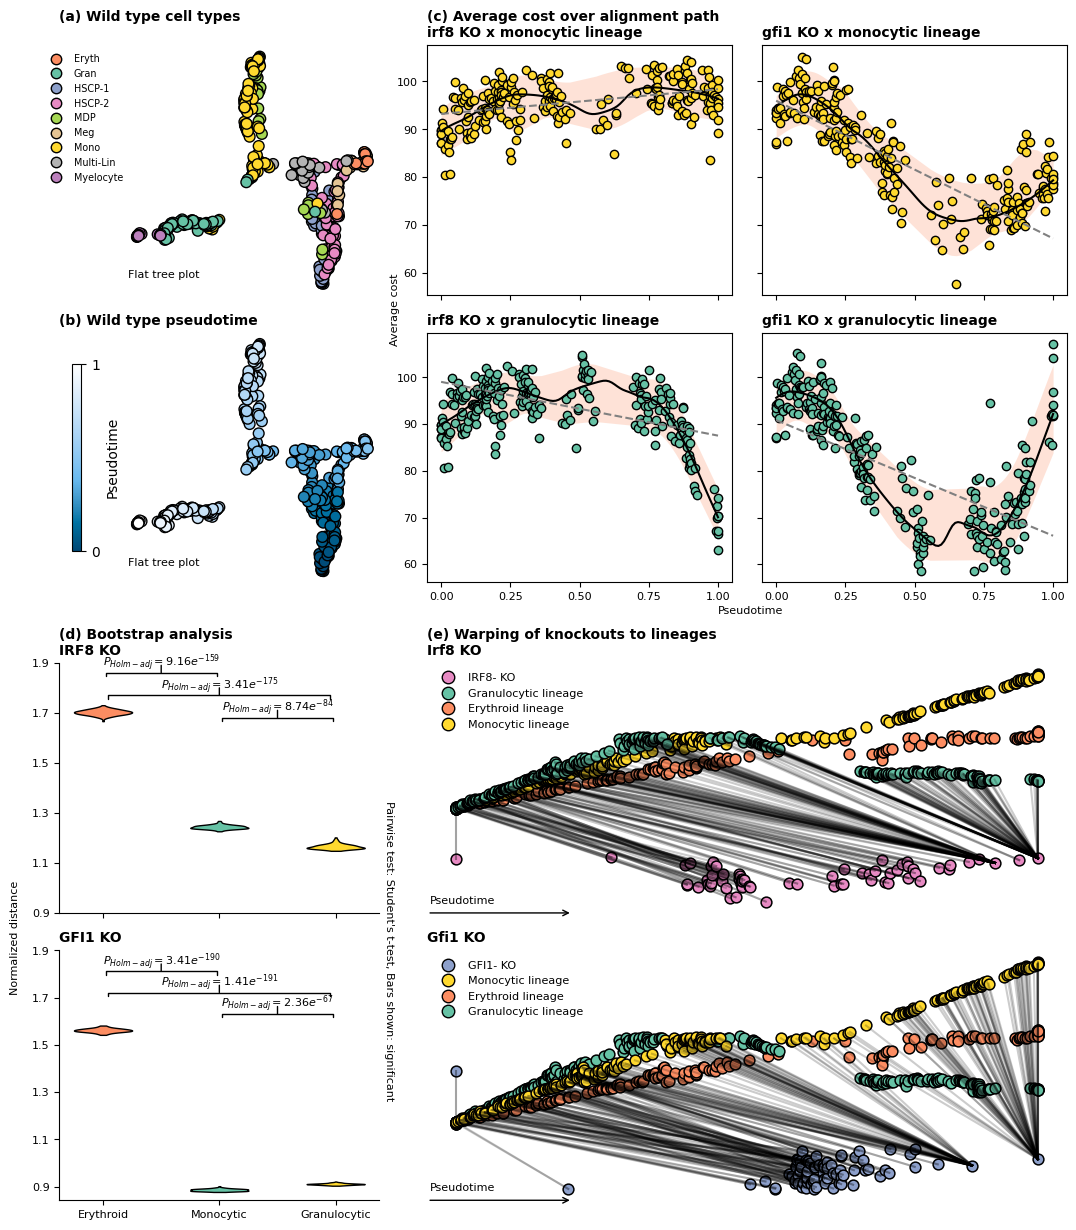

In [639]:
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)
colors = [colors[1]] + [colors[0]] + list(colors[2:5]) + [colors[6]] + [colors[5]] + list(colors[7:])

# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 10, 10, 10]})

fig = plt.figure(figsize=(13, 15))
gs_outer = fig.add_gridspec(2, 2, width_ratios = [1,2])

gsa = gs_outer[0, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
# gsbplus = gs_outer[0, 1].subgridspec(2, 1, height_ratios=[1,50])
gsb = gs_outer[0, 1].subgridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
gsc = gs_outer[1, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
gsd = gs_outer[1, 1].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)

gsa1 = gsa[0, 0].subgridspec(1, 2, width_ratios=[2, 10])
gsa2 = gsa[1, 0].subgridspec(1, 2, width_ratios=[2, 10])

axa11 = fig.add_subplot(gsa1[0, 0])
axa12 = fig.add_subplot(gsa1[0, 1])
axa21 = fig.add_subplot(gsa2[0, 0])
axa22 = fig.add_subplot(gsa2[0, 1])

plot_celltypes(adata, [axa12, axa11])
axa11.set_title("(a) Wild type cell types\n", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
plot_pseudotime(adata, [axa22, axa21], "")
axa21.set_title("(b) Wild type pseudotime", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

(axb1, axb2), (axb3, axb4) = gsb.subplots(sharex='col', sharey='row')

plot_avg_cost(lowess_irf8_mono, "irf8 KO to monocytic lineage", colors[6], axb1, removedspines=None)
plot_avg_cost(lowess_irf8_gran, "irf8 KO to granulocytic lineage", colors[1], axb3, removedspines=None)
plot_avg_cost(lowess_gfi1_mono, "gfi1 KO to monocytic lineage", colors[6], axb2, removedspines=None)
plot_avg_cost(lowess_gfi1_gran, "gfi1 KO to granulocytic lineage", colors[1], axb4, removedspines=None)

# plt.subplots_adjust(top=0.7)
axb1.set_title("(c) Average cost over alignment path\nirf8 KO x monocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb2.set_title("gfi1 KO x monocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb3.set_title("irf8 KO x granulocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axb4.set_title("gfi1 KO x granulocytic lineage", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

axb1.set_xticks([0, 0.25, 0.5, 0.75, 1])
axb2.set_xticks([0, 0.25, 0.5, 0.75, 1])

yticks = [60, 70, 80, 90, 100]
axb1.set_yticks(yticks)
axb3.set_yticks(yticks)

axb1.tick_params(axis='both', which='major', labelsize=8)
axb2.tick_params(axis='both', which='major', labelsize=8)
axb3.tick_params(axis='both', which='major', labelsize=8)
axb4.tick_params(axis='both', which='major', labelsize=8)

axb1.text(-0.15, 60, "Average cost", fontsize=8, ha='right', va='top', rotation = 90)
axb3.text(1, 50, "Pseudotime", fontsize=8, ha='left', va='center')


plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.15)

axc1 = fig.add_subplot(gsc[0, 0])
axc2 = fig.add_subplot(gsc[1, 0])

gsd1 = gsd[0, 0].subgridspec(1, 1)
gsd2 = gsd[1, 0].subgridspec(1, 1)

axd11 = fig.add_subplot(gsd1[0, 0])
# axd12 = fig.add_subplot(gsd1[0, 1])
axd21 = fig.add_subplot(gsd2[0, 0])
# axd22 = fig.add_subplot(gsd2[0, 1])

lineage_colors = {
    "Erythroid\nlineage": colors[0],
    "Monocytic\nlineage": colors[6],
    "Granulocytic\nlineage": colors[1],
    "IRF8- KO": colors[3],
    "GFI1- KO": colors[2],
}

lineage_colors = {
    "ery": (colors[0], "Erythroid lineage"),
    "mono": (colors[6], "Monocytic lineage"),
    "gran": (colors[1], "Granulocytic lineage"),
    "irf8": (colors[3], "IRF8- KO"),
    "gfi1": (colors[2], "GFI1- KO"),
}

colors_irf8 = [
    lineage_colors["irf8"],
    lineage_colors["gran"],
    lineage_colors["ery"], 
    lineage_colors["mono"]
]

plot_warping(
    warped_datasets = [warped_irf8, irf8_granulocytic],
    extra_datasets = [irf8_erythrocytic, irf8_monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap",
    yshift = -15,
    ax=axd11,
    colors = [x[0] for x in colors_irf8]
)
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c[0], color = "k", markersize = 9, lw = 0) for c in colors_irf8]
labels = [x[1] for x in colors_irf8]

axd11.legend(
    handles=handles, labels=labels, frameon=False, loc='upper left', fontsize=8
)

axd11.set_title("(e) Warping of knockouts to lineages\nIrf8 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axd21.set_title("Gfi1 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

colors_gfi1 = [
    lineage_colors["gfi1"],
    lineage_colors["mono"],
    lineage_colors["ery"],
    lineage_colors["gran"]
]

plot_warping(
    warped_datasets = [warped_gfi1, gfi1_monocytic],
    extra_datasets = [gfi1_erythrocytic, gfi1_granulocytic],
    dtw_key = "gfi1_monocytic_gfi1",
    dimred_key = "X_vis_umap",
    yshift = -8,
    ax=axd21,
    colors = [x[0] for x in colors_gfi1]
)

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c[0], color = "k", markersize = 9, lw = 0) for c in colors_gfi1]
labels = [x[1] for x in colors_gfi1]

axd21.legend(
    handles=handles, labels=labels, frameon=False, loc='upper left', fontsize=8
)

data_irf8 = pd.DataFrame({
    "ery": res_irf8[0],
    "mono": res_irf8[1],
    "gran": res_irf8[2]
})

data_gfi1 = pd.DataFrame({
    "ery": res_gfi1[0],
    "mono": res_gfi1[1],
    "gran": res_gfi1[2]
})

label1 = '$P_{Holm-adj}=9.16e^{-159}$'
label2 = '$P_{Holm-adj}=3.41e^{-175}$'
label3 = '$P_{Holm-adj}=8.74e^{-84}$'

plot_violins(data_irf8, axc1, label1, label2, label3, 1.85, 1.76, 1.67)

label1 = '$P_{Holm-adj}=3.41e^{-190}$'
label2 = '$P_{Holm-adj}=1.41e^{-191}$'
label3 = '$P_{Holm-adj}=2.36e^{-67}$'

plot_violins(data_gfi1, axc2, label1, label2, label3, 1.8, 1.71, 1.62)
# axc2.set_yticks([1.8, 1.6, 1.4, 1.2, 1.0])

axc1.set_title("(d) Bootstrap analysis\nIRF8 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")
axc2.set_title("GFI1 KO", fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc="left")

# axc1.spines["bottom"].set_visible(False)
axc1.set_xticklabels([])

stat_text = "Pairwise test: Student's t-test, Bars shown: significant"
axc1.text(3.5, 1.35, stat_text, fontsize=8, ha='right', va='top', rotation = 270)

axc1.text(0.2, 0.8, "Normalized distance", fontsize=8, ha='left', va='center', rotation = 90)


axc1.tick_params(axis='both', which='major', labelsize=8)
axc2.tick_params(axis='both', which='major', labelsize=8)

plt.savefig("figures/2_dynchro_mouse_figure.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_mouse_figure.png", bbox_inches='tight', dpi=300)


IndexError: list index out of range

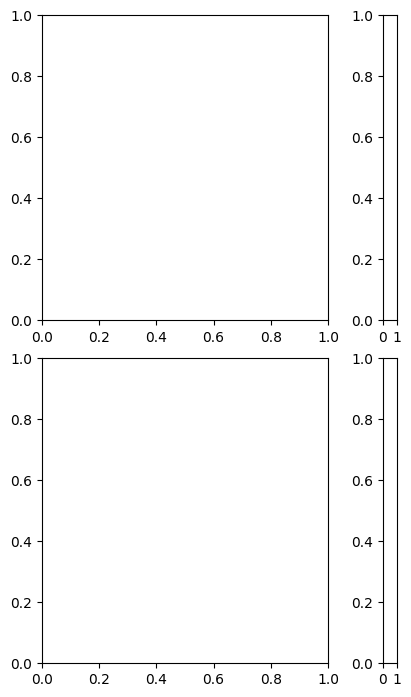

In [159]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
gs_outer = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1.5])

gsa = gs_outer[0, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
gsb = gs_outer[0, 1].subgridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
gsc = gs_outer[1, 0].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)
gsd = gs_outer[1, 1].subgridspec(2, 1, height_ratios=[1, 1], wspace=0.1)

gsa1 = gsa[0, 0].subgridspec(1, 2, width_ratios=[20, 1])
gsa2 = gsa[1, 0].subgridspec(1, 2, width_ratios=[20, 1])

axa11 = fig.add_subplot(gsa1[0, 0])
axa12 = fig.add_subplot(gsa1[0, 1])
axa21 = fig.add_subplot(gsa2[0, 0])
axa22 = fig.add_subplot(gsa2[0, 1])

plot_celltypes(adata, [ axa11, axa12])
plot_pseudotime(adata, [axa21, axa22], "Inferred pseudotime")

axb1 = fig.add_subplot(gsb[0, 0])
axb2 = fig.add_subplot(gsb[0, 1], sharey=axb1)
axb3 = fig.add_subplot(gsb[1, 0], sharex=axb1)
axb4 = fig.add_subplot(gsb[1, 1], sharex=axb2, sharey=axb3)

dynchro.pl.plot_avg_cost_path(irf8_mono, pseudotime_key="norm_pseudotime", dtw_key="irf8_monocytic_irf8", color = "#EFCB69", ax=axb1)
dynchro.pl.plot_avg_cost_path(irf8_gran, pseudotime_key="norm_pseudotime", dtw_key="irf8_granulocytic_irf8", color = "#EFCB69", ax=axb3)
dynchro.pl.plot_avg_cost_path(gfi1_mono, pseudotime_key="norm_pseudotime", dtw_key="gfi1_monocytic_gfi1", color="#EF7269", ax=axb2)
dynchro.pl.plot_avg_cost_path(gfi1_gran, pseudotime_key="norm_pseudotime", dtw_key="gfi1_granulocytic_gfi1", color="#EF7269", ax=axb4)

axb1.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
axb2.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
axb3.spines[['top', 'right', 'left']].set_visible(False)
axb4.spines[['top', 'right', 'left']].set_visible(False)

axc1 = fig.add_subplot(gsc[0, 0])
axc2 = fig.add_subplot(gsc[1, 0])

axc1.set_title("irf8 KO")
axc2.set_title("gfi1 KO")

axc1.spines[['top', 'right']].set_visible(False)
axc2.spines[['top', 'right']].set_visible(False)

sns.violinplot(data=data_irf8, palette=["#EFCB69", "#EFCB69", "#EFCB69"], ax=axc1)
sns.violinplot(data=data_gfi1, palette=["#EF7269", "#EF7269", "#EF7269"], ax=axc2)

# add gridspec to gsd
gsd1 = gsd[0, 0].subgridspec(1, 2, width_ratios=[8, 2])
gsd2 = gsd[1, 0].subgridspec(1, 2, width_ratios=[8, 2])

axd11 = fig.add_subplot(gsd1[0, 0])
axd12 = fig.add_subplot(gsd1[0, 1])
axd21 = fig.add_subplot(gsd2[0, 0])
axd22 = fig.add_subplot(gsd2[0, 1])

colors_warping = [
    "#EFCB69",
    "#FF9784",
    "#EE7FC7",
    "#69BAEF"
    ]

plot_warping(
    warped_datasets = [warped_irf8, irf8_granulocytic],
    extra_datasets = [irf8_erythrocytic, irf8_monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap",
    yshift = -15,
    ax=axd11,
    colors = colors_warping
)
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors_warping[:4]]
labels = ["IRF8-", "Granulocytic", "Erythrocytic", "Monocytic"]

# no spines and ticks
axd12.axis('off')
axd12.legend(
    handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
    bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11
)

plot_warping(
    warped_datasets = [warped_gfi1, gfi1_monocytic],
    extra_datasets = [gfi1_erythrocytic, gfi1_granulocytic],
    dtw_key = "gfi1_monocytic_gfi1",
    dimred_key = "X_vis_umap",
    yshift = -8,
    ax=axd21,
    colors = colors_warping
)

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors_warping[:4]]
labels = ["GFI1-", "Monocytic", "Erythrocytic", "Granulocytic"]
axd22.axis('off')
axd22.legend(
    handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
    bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11
)

# save figure
fig.savefig("figures/dynchro_mouse.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figures/dynchro_mouse.png", bbox_inches='tight', dpi=300)


IndexError: list index out of range

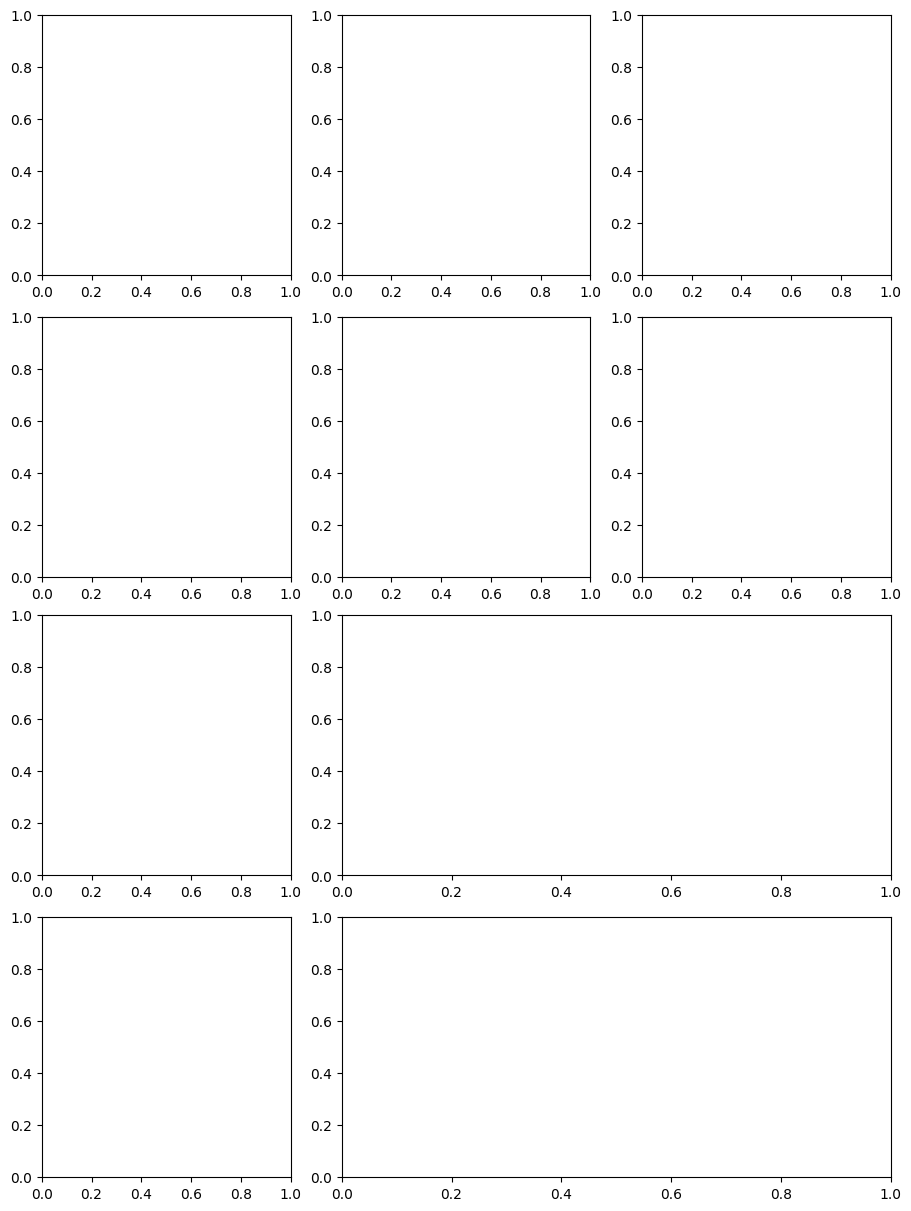

In [160]:
scatters = [["a1"], ["a2"]]
costs = [["b1", "b2"], ["b3", "b4"]]
bootstraps = [["c1"], ["c2"]]
warpings = [["d1"], ["d2"]]

outer_nested = [
    [scatters, costs],
    [bootstraps, warpings]
]




axd = plt.figure(figsize=(9, 12), layout="constrained").subplot_mosaic(
    outer_nested, empty_sentinel=None,
    width_ratios=[1, 2]
)

plot_celltypes(adata, axd["a1"])
plot_pseudotime(adata, axd["a2"], "pseudotime on wildtype")

dynchro.pl.plot_avg_cost_path(irf8_mono, pseudotime_key="norm_pseudotime", dtw_key="irf8_monocytic_irf8", color = "#EFCB69", ax=axd["b1"])
dynchro.pl.plot_avg_cost_path(irf8_gran, pseudotime_key="norm_pseudotime", dtw_key="irf8_granulocytic_irf8", color = "#EFCB69", ax=axd["b2"])
dynchro.pl.plot_avg_cost_path(gfi1_mono, pseudotime_key="norm_pseudotime", dtw_key="gfi1_monocytic_gfi1", color="#EF7269", ax=axd["b3"])
dynchro.pl.plot_avg_cost_path(gfi1_gran, pseudotime_key="norm_pseudotime", dtw_key="gfi1_granulocytic_gfi1", color="#EF7269", ax=axd["b4"])

sns.violinplot(data=data_irf8, palette=["#EFCB69", "#EFCB69", "#EFCB69"], ax=axd["c1"])
sns.violinplot(data=data_gfi1, palette=["#EF7269", "#EF7269", "#EF7269"], ax=axd["c2"])
# identify_axes(axd, fontsize=36)

In [121]:
axd

{'a1': <Axes: label='a1'>,
 'a2': <Axes: label='a2'>,
 'b1': <Axes: label='b1'>,
 'b2': <Axes: label='b2'>,
 'b3': <Axes: label='b3'>,
 'b4': <Axes: label='b4'>,
 'c1': <Axes: label='c1'>,
 'c2': <Axes: label='c2'>,
 'd1': <Axes: label='d1'>,
 'd2': <Axes: label='d2'>}

In [199]:
adata

AnnData object with n_obs × n_vars = 382 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'id', 'label_colors', 'lineage_labels', 'lineages', 'var_genes', 'workdir'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'